# JARTIC Traffic Data Analysis - 2023 Dataset

Analysis of traffic volume data from JARTIC for 2023.

**Version**: V2

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
data_path = '/Users/vojtech/Code/Bard89/Project-Data/data/processed/jp_jartic_processed_20230101_to_20231231.csv'
print(f"Loading JARTIC data from: {data_path}")

df = pd.read_csv(data_path)
df['timestamp'] = pd.to_datetime(df['timestamp'])

print(f"Dataset shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

Loading JARTIC data from: /Users/vojtech/Code/Bard89/Project-Data/data/processed/jp_jartic_processed_20230101_to_20231231.csv
Dataset shape: 8,677,621 rows × 13 columns
Date range: 2022-12-31 15:00:00+00:00 to 2023-12-31 14:00:00+00:00
Memory usage: 2726.7 MB


In [3]:
df_2023 = df[(df['timestamp'] >= '2023-01-01') & (df['timestamp'] < '2024-01-01')]
print(f"2023 data: {len(df_2023):,} records")
print(f"2023 date range: {df_2023['timestamp'].min()} to {df_2023['timestamp'].max()}")

2023 data: 8,668,679 records
2023 date range: 2023-01-01 00:00:00+00:00 to 2023-12-31 14:00:00+00:00


## 1. Dataset Overview

In [4]:
print("Dataset Info:")
print("="*60)
print(f"Total records: {len(df_2023):,}")
print(f"Unique hexagons (res8): {df_2023['h3_index_res8'].nunique():,}")
print(f"Date range: {df_2023['timestamp'].min()} to {df_2023['timestamp'].max()}")
print(f"\nColumns ({len(df_2023.columns)}):")
for col in df_2023.columns:
    print(f"  - {col}: {df_2023[col].dtype}")

Dataset Info:
Total records: 8,668,679
Unique hexagons (res8): 1,017
Date range: 2023-01-01 00:00:00+00:00 to 2023-12-31 14:00:00+00:00

Columns (13):
  - timestamp: datetime64[ns, UTC]
  - h3_index_res8: object
  - avg_traffic_volume: float64
  - max_traffic_volume: int64
  - traffic_volume_std: float64
  - measurement_count: int64
  - avg_distance: float64
  - unique_links: int64
  - h3_lat_res8: float64
  - h3_lon_res8: float64
  - prefecture: object
  - data_source: object
  - country: object


In [5]:
print("First 10 rows:")
display(df_2023.head(10))

print("\nLast 10 rows:")
display(df_2023.tail(10))

First 10 rows:


,timestamp,h3_index_res8,avg_traffic_volume,max_traffic_volume,traffic_volume_std,measurement_count,avg_distance,unique_links,h3_lat_res8,h3_lon_res8,prefecture,data_source,country
8942,2023-01-01 00:00:00+00:00,882f5a44cdfffff,24.37,66,15.96,38,48.13,38,36.13,140.19,ibaraki,jartic,JP
8943,2023-01-01 00:00:00+00:00,882f5a4ae5fffff,25.30,58,13.88,27,37.52,27,36.29,140.43,ibaraki,jartic,JP
8944,2023-01-01 00:00:00+00:00,882f5a49e9fffff,19.78,104,19.64,259,27.21,259,36.38,140.44,ibaraki,jartic,JP
8945,2023-01-01 00:00:00+00:00,882f5a4747fffff,49.33,72,20.26,3,7.00,3,36.12,140.31,ibaraki,jartic,JP
8946,2023-01-01 00:00:00+00:00,882f5a4155fffff,41.00,66,35.36,2,35.50,2,36.21,140.43,ibaraki,jartic,JP
8947,2023-01-01 00:00:00+00:00,882f5a3217fffff,21.43,185,16.61,593,26.39,593,35.71,139.81,tokyo,jartic,JP
8948,2023-01-01 00:00:00+00:00,882f5a398bfffff,39.80,63,15.37,10,89.70,10,35.95,139.81,chiba,jartic,JP
8949,2023-01-01 00:00:00+00:00,882f5a371dfffff,23.98,151,18.74,364,33.89,364,35.71,139.69,tokyo,jartic,JP
8950,2023-01-01 00:00:00+00:00,882f5a352dfffff,19.19,63,14.21,93,21.73,91,35.79,139.69,saitama,jartic,JP
8951,2023-01-01 00:00:00+00:00,882f5a34d7fffff,25.71,111,24.82,192,43.47,192,35.71,139.56,tokyo,jartic,JP



Last 10 rows:


,timestamp,h3_index_res8,avg_traffic_volume,max_traffic_volume,traffic_volume_std,measurement_count,avg_distance,unique_links,h3_lat_res8,h3_lon_res8,prefecture,data_source,country
8677611,2023-12-31 14:00:00+00:00,882e625651fffff,8.00,13,4.64,5,44.80,5,36.13,137.19,gifu,jartic,JP
8677612,2023-12-31 14:00:00+00:00,882e626581fffff,0.00,0,NaN,1,20.00,1,36.37,136.56,ishikawa,jartic,JP
8677613,2023-12-31 14:00:00+00:00,882e626cd5fffff,10.20,46,12.62,30,37.80,30,36.46,136.56,ishikawa,jartic,JP
8677614,2023-12-31 14:00:00+00:00,882e626f0bfffff,1.00,1,NaN,1,8.00,1,36.46,136.69,ishikawa,jartic,JP
8677615,2023-12-31 14:00:00+00:00,882e62b34bfffff,4.00,6,2.00,7,70.86,7,35.54,136.94,gifu,jartic,JP
8677616,2023-12-31 14:00:00+00:00,882e62b6cbfffff,8.15,16,3.56,20,39.15,20,35.46,136.69,gifu,jartic,JP
8677617,2023-12-31 14:00:00+00:00,882e62bb11fffff,7.00,7,NaN,1,39.00,1,35.71,136.94,gifu,jartic,JP
8677618,2023-12-31 14:00:00+00:00,882e62cd51fffff,5.25,10,3.77,4,14.00,4,36.12,137.32,gifu,jartic,JP
8677619,2023-12-31 14:00:00+00:00,882e61cec1fffff,0.00,0,NaN,1,11.00,1,34.71,135.93,nara,jartic,JP
8677620,2023-12-31 14:00:00+00:00,884b757ab7fffff,8.00,8,NaN,1,94.00,1,31.54,130.43,kagoshima,jartic,JP


## 2. Temporal Coverage Analysis

In [6]:
df_2023['date'] = df_2023['timestamp'].dt.date
all_dates_2023 = pd.date_range('2023-01-01', '2023-12-31', freq='D').date
existing_dates = set(df_2023['date'].unique())
missing_dates = sorted(set(all_dates_2023) - existing_dates)

print(f"Temporal Coverage Analysis for 2023:")
print("="*60)
print(f"Expected days in 2023: 365")
print(f"Days with data: {len(existing_dates)}")
print(f"Missing days: {len(missing_dates)}")
print(f"Coverage: {len(existing_dates)/365*100:.1f}%")

print(f"\n✓ COMPLETE YEAR COVERAGE" if len(existing_dates) >= 364 else f"\n⚠️ INCOMPLETE COVERAGE")

print("\nMonthly coverage:")
monthly_counts = df_2023.groupby(df_2023['timestamp'].dt.to_period('M')).size()
all_months = pd.period_range('2023-01', '2023-12', freq='M')
for month in all_months:
    actual_records = monthly_counts.get(month, 0)
    print(f"  {month}: {actual_records:,} records")

Temporal Coverage Analysis for 2023:
Expected days in 2023: 365
Days with data: 365
Missing days: 0
Coverage: 100.0%

✓ COMPLETE YEAR COVERAGE

Monthly coverage:
  2023-01: 736,969 records
  2023-02: 665,792 records
  2023-03: 738,459 records
  2023-04: 714,955 records
  2023-05: 738,586 records
  2023-06: 714,332 records
  2023-07: 737,833 records
  2023-08: 737,278 records
  2023-09: 713,287 records
  2023-10: 734,123 records
  2023-11: 710,779 records
  2023-12: 726,286 records


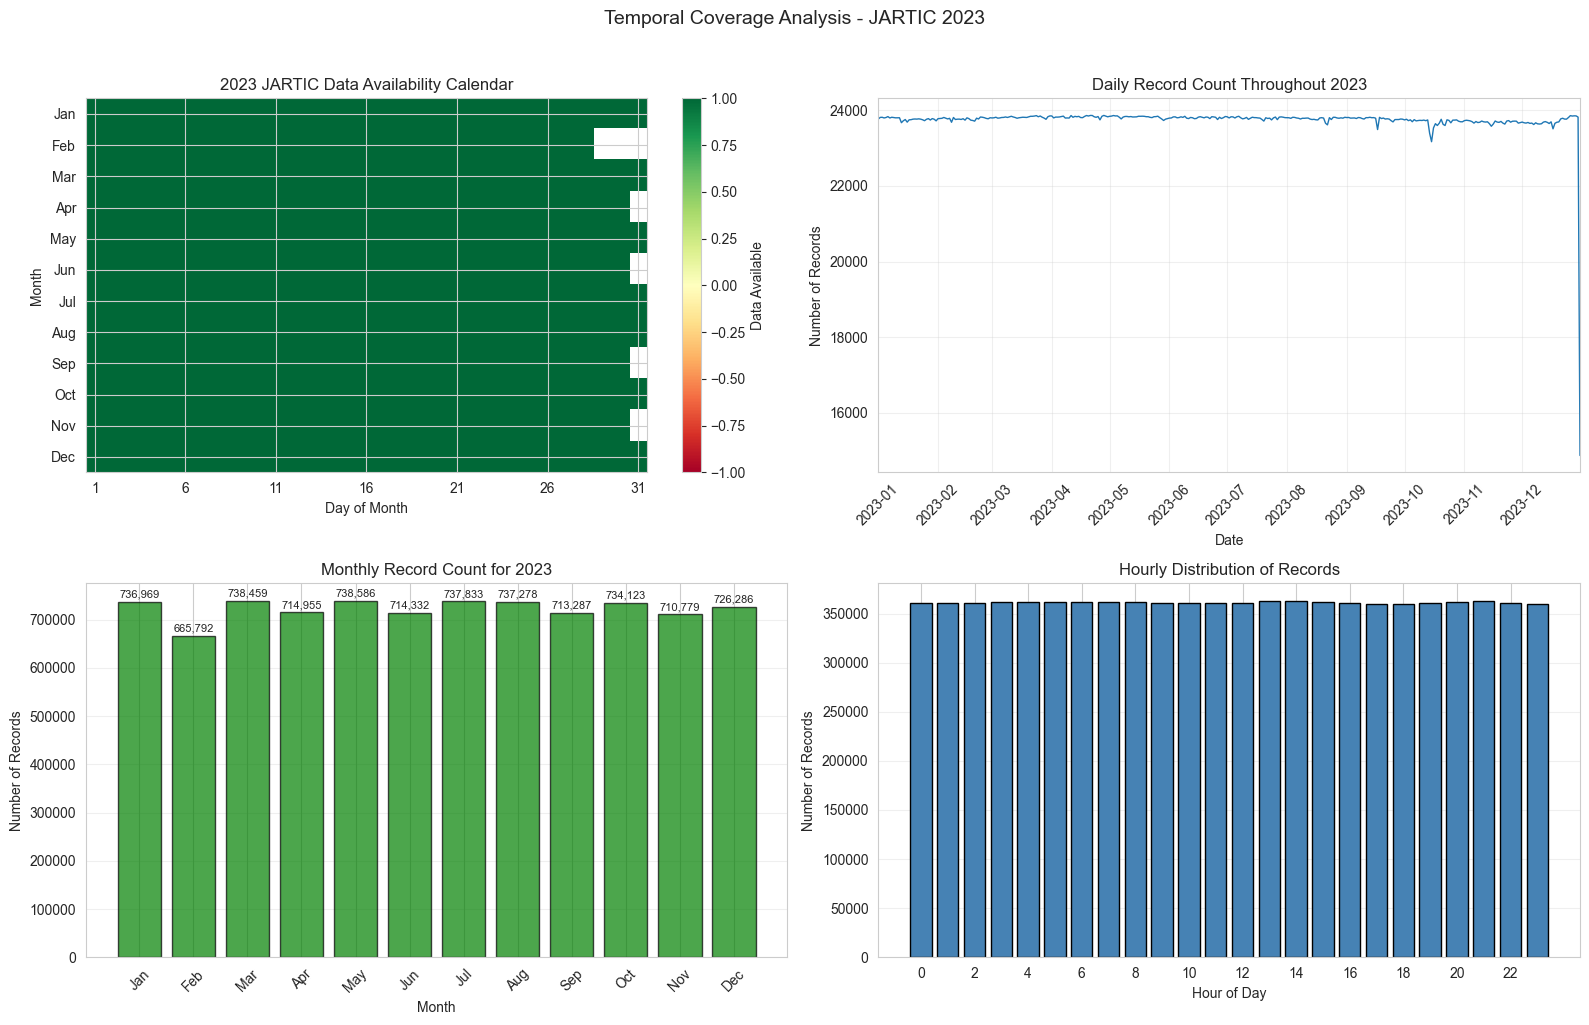

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

calendar_data = np.zeros((12, 31))
for date in all_dates_2023:
    month = date.month - 1
    day = date.day - 1
    if day < 31:
        calendar_data[month, day] = 1 if date in existing_dates else -1

calendar_data[calendar_data == 0] = np.nan

im = axes[0, 0].imshow(calendar_data, cmap='RdYlGn', aspect='auto', vmin=-1, vmax=1)
axes[0, 0].set_title('2023 JARTIC Data Availability Calendar', fontsize=12)
axes[0, 0].set_xlabel('Day of Month')
axes[0, 0].set_ylabel('Month')
axes[0, 0].set_yticks(range(12))
axes[0, 0].set_yticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[0, 0].set_xticks(range(0, 31, 5))
axes[0, 0].set_xticklabels(range(1, 32, 5))
plt.colorbar(im, ax=axes[0, 0], label='Data Available')

date_range = pd.date_range('2023-01-01', '2023-12-31', freq='D')
daily_counts = df_2023.groupby('date').size().reindex(date_range.date, fill_value=0)
axes[0, 1].plot(daily_counts.index, daily_counts.values, linewidth=1)
axes[0, 1].set_title('Daily Record Count Throughout 2023', fontsize=12)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Number of Records')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_xlim(date_range[0], date_range[-1])
axes[0, 1].grid(True, alpha=0.3)

monthly_coverage = df_2023.groupby(df_2023['timestamp'].dt.to_period('M')).size().reindex(all_months, fill_value=0)
colors = ['green' if val > 0 else 'red' for val in monthly_coverage.values]
bars = axes[1, 0].bar(range(12), monthly_coverage.values, color=colors, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Monthly Record Count for 2023', fontsize=12)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Number of Records')
axes[1, 0].set_xticks(range(12))
axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                             'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, monthly_coverage.values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5000,
                    f'{val:,}', ha='center', va='bottom', fontsize=8)

hourly_counts = df_2023.groupby(df_2023['timestamp'].dt.hour).size()
axes[1, 1].bar(hourly_counts.index, hourly_counts.values, color='steelblue', edgecolor='black')
axes[1, 1].set_title('Hourly Distribution of Records', fontsize=12)
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Number of Records')
axes[1, 1].set_xticks(range(0, 24, 2))
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Temporal Coverage Analysis - JARTIC 2023', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 3. Traffic Volume Analysis

In [8]:
traffic_columns = [col for col in df_2023.columns if 'traffic' in col.lower() and 'volume' in col.lower()]
print(f"Traffic volume columns found: {traffic_columns}")

missing_stats = pd.DataFrame({
    'Missing Count': df_2023[traffic_columns].isnull().sum(),
    'Missing %': (df_2023[traffic_columns].isnull().sum() / len(df_2023) * 100).round(2),
    'Available Count': df_2023[traffic_columns].notnull().sum(),
    'Available %': (df_2023[traffic_columns].notnull().sum() / len(df_2023) * 100).round(2)
})

print("\nTraffic Data Completeness:")
print("="*60)
display(missing_stats)

Traffic volume columns found: ['avg_traffic_volume', 'max_traffic_volume', 'traffic_volume_std']

Traffic Data Completeness:


,Missing Count,Missing %,Available Count,Available %
avg_traffic_volume,0,0.00,8668679,100.00
max_traffic_volume,0,0.00,8668679,100.00
traffic_volume_std,557626,6.43,8111053,93.57


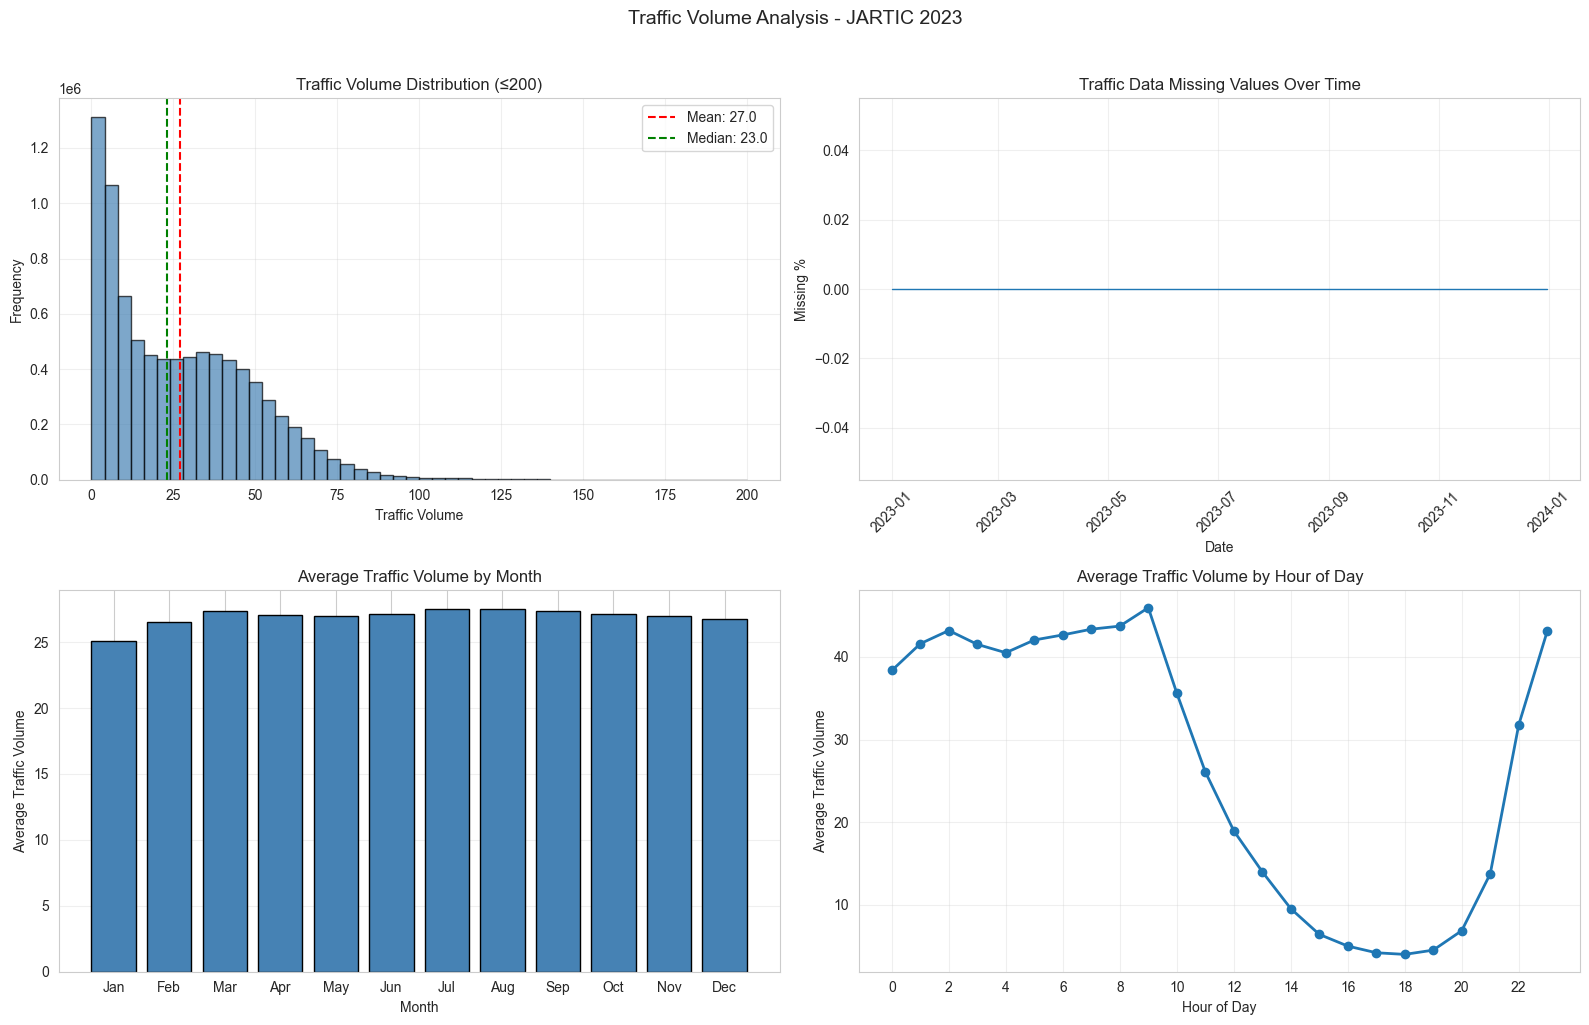

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

traffic_mean = df_2023['avg_traffic_volume'].dropna()
axes[0, 0].hist(traffic_mean[traffic_mean <= 200], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('Traffic Volume')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Traffic Volume Distribution (≤200)')
axes[0, 0].axvline(traffic_mean.mean(), color='red', linestyle='--', label=f'Mean: {traffic_mean.mean():.1f}')
axes[0, 0].axvline(traffic_mean.median(), color='green', linestyle='--', label=f'Median: {traffic_mean.median():.1f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

daily_traffic_missing = df_2023.groupby('date')['avg_traffic_volume'].apply(lambda x: x.isnull().mean() * 100)
axes[0, 1].plot(daily_traffic_missing.index, daily_traffic_missing.values, linewidth=1)
axes[0, 1].set_title('Traffic Data Missing Values Over Time', fontsize=12)
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Missing %')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

monthly_traffic = df_2023.groupby(df_2023['timestamp'].dt.month)['avg_traffic_volume'].mean()
axes[1, 0].bar(monthly_traffic.index, monthly_traffic.values, color='steelblue', edgecolor='black')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Traffic Volume')
axes[1, 0].set_title('Average Traffic Volume by Month')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                            'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1, 0].grid(True, alpha=0.3, axis='y')

hourly_traffic = df_2023.groupby(df_2023['timestamp'].dt.hour)['avg_traffic_volume'].mean()
axes[1, 1].plot(hourly_traffic.index, hourly_traffic.values, marker='o', linewidth=2)
axes[1, 1].set_xlabel('Hour of Day')
axes[1, 1].set_ylabel('Average Traffic Volume')
axes[1, 1].set_title('Average Traffic Volume by Hour of Day')
axes[1, 1].set_xticks(range(0, 24, 2))
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Traffic Volume Analysis - JARTIC 2023', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 4. Geographic Coverage

In [10]:
hex_locations = df_2023[['h3_index_res8', 'h3_lat_res8', 'h3_lon_res8']].drop_duplicates()
print(f"Geographic Coverage:")
print("="*60)
print(f"Unique hexagons: {len(hex_locations):,}")
print(f"Latitude range: {hex_locations['h3_lat_res8'].min():.2f} to {hex_locations['h3_lat_res8'].max():.2f}")
print(f"Longitude range: {hex_locations['h3_lon_res8'].min():.2f} to {hex_locations['h3_lon_res8'].max():.2f}")

hex_data_counts = df_2023.groupby('h3_index_res8').agg({
    'avg_traffic_volume': ['count', 'mean', lambda x: x.notna().mean()]
}).reset_index()
hex_data_counts.columns = ['h3_index_res8', 'record_count', 'traffic_mean', 'traffic_coverage']
hex_with_counts = hex_locations.merge(hex_data_counts, on='h3_index_res8')

print(f"\nRecords per hexagon:")
print(f"  Mean: {hex_with_counts['record_count'].mean():.0f}")
print(f"  Median: {hex_with_counts['record_count'].median():.0f}")
print(f"  Min: {hex_with_counts['record_count'].min()}")
print(f"  Max: {hex_with_counts['record_count'].max()}")

print(f"\nTraffic data completeness per hexagon:")
print(f"  Mean: {hex_with_counts['traffic_coverage'].mean():.1%}")
print(f"  Median: {hex_with_counts['traffic_coverage'].median():.1%}")

Geographic Coverage:
Unique hexagons: 1,017
Latitude range: 26.12 to 45.38
Longitude range: 127.69 to 144.44

Records per hexagon:
  Mean: 8524
  Median: 8748
  Min: 1
  Max: 8751

Traffic data completeness per hexagon:
  Mean: 100.0%
  Median: 100.0%


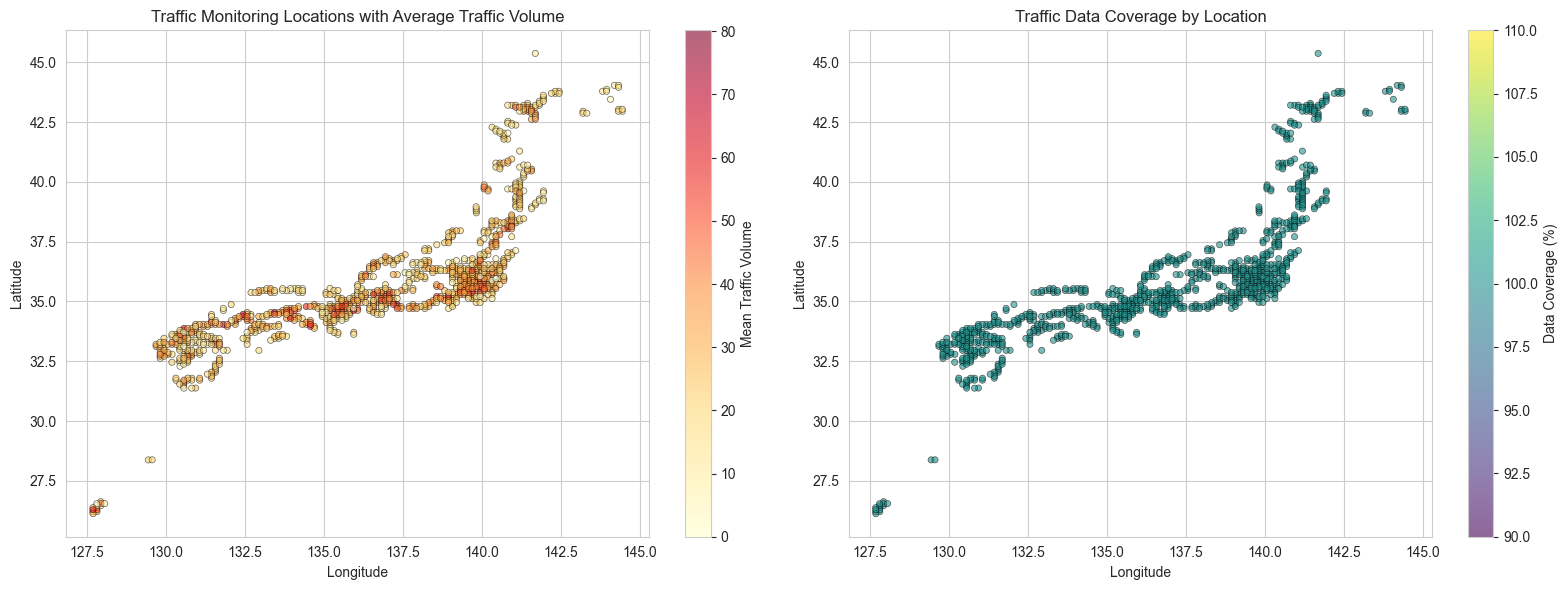

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter = axes[0].scatter(hex_with_counts['h3_lon_res8'],
                         hex_with_counts['h3_lat_res8'],
                         c=hex_with_counts['traffic_mean'],
                         cmap='YlOrRd', s=20, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Traffic Monitoring Locations with Average Traffic Volume')
plt.colorbar(scatter, ax=axes[0], label='Mean Traffic Volume')

scatter2 = axes[1].scatter(hex_with_counts['h3_lon_res8'],
                          hex_with_counts['h3_lat_res8'],
                          c=hex_with_counts['traffic_coverage']*100,
                          cmap='viridis', s=20, alpha=0.6, edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Traffic Data Coverage by Location')
plt.colorbar(scatter2, ax=axes[1], label='Data Coverage (%)')

plt.tight_layout()
plt.show()

## 5. Temporal Patterns

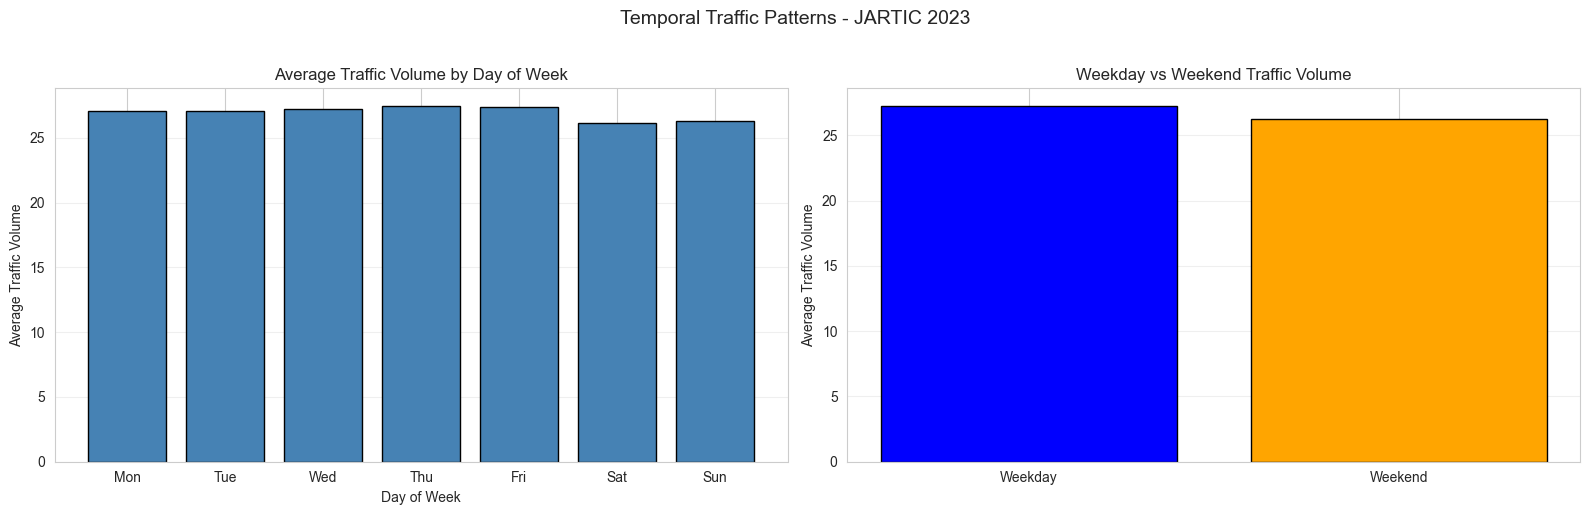

In [12]:
df_2023['dayofweek'] = df_2023['timestamp'].dt.dayofweek
df_2023['is_weekend'] = df_2023['dayofweek'].isin([5, 6])

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

dow_traffic = df_2023.groupby('dayofweek')['avg_traffic_volume'].mean()
axes[0].bar(dow_traffic.index, dow_traffic.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Average Traffic Volume')
axes[0].set_title('Average Traffic Volume by Day of Week')
axes[0].set_xticks(range(7))
axes[0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
axes[0].grid(True, alpha=0.3, axis='y')

weekend_comparison = df_2023.groupby('is_weekend')['avg_traffic_volume'].mean()
axes[1].bar(['Weekday', 'Weekend'], weekend_comparison.values, color=['blue', 'orange'], edgecolor='black')
axes[1].set_ylabel('Average Traffic Volume')
axes[1].set_title('Weekday vs Weekend Traffic Volume')
axes[1].grid(True, alpha=0.3, axis='y')

plt.suptitle('Temporal Traffic Patterns - JARTIC 2023', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Statistical Summary

In [13]:
print("Traffic Volume Statistical Summary:")
print("="*60)
display(df_2023[traffic_columns].describe())

Traffic Volume Statistical Summary:


,avg_traffic_volume,max_traffic_volume,traffic_volume_std
count,8668679.00,8668679.00,8111053.00
mean,26.96,57.60,13.80
std,22.19,54.46,11.65
min,0.00,0.00,0.00
25%,7.00,16.00,4.36
50%,23.00,44.00,10.88
75%,42.37,82.00,20.29
max,288.00,9440.00,907.60


In [ ]:
print("JARTIC 2023 DATA QUALITY SUMMARY")
print("="*60)

print("\n📊 DATASET OVERVIEW:")
print(f"   Total records: {len(df_2023):,}")
print(f"   Time period: {df_2023['timestamp'].min().date()} to {df_2023['timestamp'].max().date()}")
print(f"   Unique locations (hexagons): {df_2023['h3_index_res8'].nunique()}")
print(f"   Temporal resolution: Hourly")

print("\n📅 TEMPORAL COVERAGE:")
print(f"   Days with data: {len(existing_dates)}/365 ({len(existing_dates)/365*100:.1f}%)")
print(f"   ✓ COMPLETE YEAR COVERAGE" if len(existing_dates) >= 364 else f"   ⚠️ Partial coverage")
print(f"   ✓ January-June 2023: AVAILABLE")
print(f"   ✓ July-December 2023: AVAILABLE")

print("\n🚗 TRAFFIC STATISTICS:")
print(f"   Mean: {traffic_mean.mean():.2f}")
print(f"   Median: {traffic_mean.median():.2f}")
print(f"   Std Dev: {traffic_mean.std():.2f}")
print(f"   Min: {traffic_mean.min():.2f}")
print(f"   Max: {traffic_mean.max():.2f}")
print(f"   95th percentile: {traffic_mean.quantile(0.95):.2f}")

print("\n✅ DATA COMPLETENESS:")
for col in traffic_columns:
    completeness = df_2023[col].notna().mean() * 100
    print(f"   {col}: {completeness:.1f}%")

print("\n🟢 KEY FINDING:")
print("   JARTIC traffic data has COMPLETE coverage for all of 2023.")
print("   This confirms that the missing Jan-Jul 13 period in the enriched")
print("   dataset is due to OpenAQ PM2.5 data availability, not traffic data.")

JARTIC 2023 DATA QUALITY SUMMARY

📊 DATASET OVERVIEW:
   Total records: 8,668,679
   Time period: 2023-01-01 to 2023-12-31
   Unique locations (hexagons): 1017
   Temporal resolution: Hourly

📅 TEMPORAL COVERAGE:
   Days with data: 365/365 (100.0%)
   ✓ COMPLETE YEAR COVERAGE
   ✓ January-June 2023: AVAILABLE
   ✓ July-December 2023: AVAILABLE

🚗 TRAFFIC STATISTICS:
   Mean: 26.96
   Median: 23.00
   Std Dev: 22.19
   Min: 0.00
   Max: 288.00
   95th percentile: 66.62

✅ DATA COMPLETENESS:
   avg_traffic_volume: 100.0%
   max_traffic_volume: 100.0%
   traffic_volume_std: 93.6%

🟢 KEY FINDING:
   JARTIC traffic data has COMPLETE coverage for all of 2023.
   This confirms that the missing Jan-Jul 13 period in the enriched
   dataset is due to OpenAQ PM2.5 data availability, not traffic data.


: 